# Final Results
---

This script outlines the final results from the thesis titled 
*Deep fMRI Encoding Models of Human Vision* by Shawn Carere. Since this repository was used for a lot of exploratory analysis, it may not be immediately clear to the reader how all of the different analysis scripts were used to obtain the results. So in this notebook we generate all figures from the
thesis to clearly outline how they were obtained. Note we also place references at the end for readability

---
---

## Chapter 3: Materials and Methods

### 3.1 - Datasets

---

The two datasets used in this work are what we refer to as the ImageNet-fMRI dataset from Horikawa et al [1] (obtained [here](http://brainliner.jp/data/brainliner/Generic_Object_Decoding)) and the MNIST-fMRI dataset from van Gerven et al. [2] (obtained [here](https://data.donders.ru.nl/collections/di/dcc/DSC_2018.00112_485?0))

The image id's can be obtained from [here](https://github.com/WeizmannVision/ssfmri2im/tree/master/KamitaniData)

#### Setup

In [30]:
# Some setup
import sys
sys.path.append('..')
from os.path import join
base_dir = '../'
# The path to the matlab file containing the fMRI data for Subject 3 from ImageNet-fMRI:
matlab_file = join(base_dir, 'kamitani_data/fmri/Subject3.mat')
# Path to the csv's containing the filenames and corresponding id's of images
test_image_ids = join(base_dir, 'kamitani_data/images/image_test_id.csv')
train_image_ids = join(base_dir, 'kamitani_data/images/image_training_id.csv')
# File containing the preprocessed images, obtained by running capsnet/misc/kamitani_image_prepare.py. Just adjust the paths of the image_generate function and set size to 112
images_npz = join(base_dir, 'kamitani_data/images/images_112.npz')
mnist_fmri_mat = join(base_dir, 'misc/69dataset_split.mat') # MNIST fMRI dataset with the same train-test split that we used

#### Load ImageNet-fMRI dataset

In [31]:
from misc import helper_functions
x_train_imagenet, x_test_imagenet, y_train_imagenet, y_test_imagenet, xyz = helper_functions.load_data(
  matlab_file=matlab_file,
  test_img_ids=test_image_ids,
  train_img_ids=train_image_ids,
  images_npz=images_npz,
  roi='ROI_VC'
)
# xyz are just the coordinates of the voxels in 3d space use to map them to their spatial location in a 3d volume

#### Load the MNIST-fMRI dataset

Note that we randomly split the data into train and validation sets.

In [32]:
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
mnist_fmri = loadmat(mnist_fmri_mat)
x_train_mnist = mnist_fmri['x_train']
x_test_mnist = mnist_fmri['x_test']
y_test_mnist = mnist_fmri['y_test']
y_train_mnist = mnist_fmri['y_train']
scaler = StandardScaler()
y_train_mnist = scaler.fit_transform(y_train_mnist)
y_test_mnist  = scaler.transform(y_test_mnist)

### 3.4 Model Evaluation

---

#### Metrics

In [33]:
import numpy as np
from scipy import stats

#Define metrics as functions, mainly so that they can be used for bagging
'''For all the below functions:

Args:
  y_pred: The predicted fMRI brain activity with shape (NUM_SAMPLES, NUM_VOXELS)
  y_pred: The 'ground truth' or measured fMRI brain activity with shape (NUM_SAMPLES, NUM_VOXELS)

'''

def voxel_corr(y_pred, y_true):
  '''Calculates the voxelwise correlations for each voxel

  Returns:
    vc: Array of voxelwise correlation coefficients with shape (NUM_VOXELS)
  '''
  NUM_VOXELS = np.shape(y_pred)[1]
  vc = []
  for i in range(NUM_VOXELS):
    vc.append(stats.pearsonr(y_pred[:, i], y_true[:, i])[0]) 
  return np.array(vc)

def vc_mean(y_pred, y_true):
  '''Calculates the average voxelwise correlation across all voxels

  Returns:
    vc_mean : Scalar value which is avarage voxelwise correlation across all voxels
      in y_pred/y_true
  '''
  return np.mean(voxel_corr(y_pred, y_true))

def vc_top100_mean(y_pred, y_true):
  '''Calculates the average voxelwise correlation of the 100 most highly correlated
    voxels

  Returns:
    vc_mean_top100: Scalar value which is average voxelwise correlation across the
      100 voxels with the highest voxelwise correlations
  '''
  vc = voxel_corr(y_pred, y_true)
  vc_sort = np.sort(vc)
  return np.mean(vc_sort[-100:])

def sample_corr(y_pred, y_true):
  '''Calculates the samplewise correlation coefficients for each sample

  Returns:
    sc: Array of samplewise correlation coefficients with shape (NUM_SAMPLES)
  '''
  NUM_SAMPLES = np.shape(y_pred)[0]
  sc = []
  for i in range(NUM_SAMPLES):
    sc.append(stats.pearsonr(y_pred[i], y_true[i])[0])
  return np.array(sc)

def sc_mean(y_pred, y_true):
  '''Calculates the average samplewise correlation across all samples

  Returns:
    sc_mean : Scalar value which is avarage samplewise correlation across all samples
      in y_pred/y_true
  '''
  return np.mean(sample_corr(y_pred, y_true))

def response_sensitivity(y_pred, y_true):
  '''Calculates the voxel response sensitivities for each voxel

  Returns:
    rs: Array of voxel response sensitivities with shape (NUM_VOXELS)
  '''
  return np.std(y_pred, axis=0)

def rs_mean(y_pred, y_true):
  '''Calculates average voxel response sensitivity across alll voxels

  Returns:
    rs_mean: Scalar value which is average voxel response sensitivity across all
      voxels in y-pred/y_true
  '''
  return np.mean(response_sensitivity(y_pred, y_true))

def response_weighted_corr(y_pred, y_true):
  '''Calculates the response weighted correlation for each voxel

  Returns:
    rwc: Array of response weighted correlations with shape (NUM_VOXELS)
  '''
  vc = voxel_corr(y_pred, y_true)
  rs = response_sensitivity(y_pred, y_true)
  vcrs = vc * rs
  rwc = np.sign(vcrs)*np.sqrt(abs(vcrs))
  return rwc

def rwc_mean(y_pred, y_true):
  '''Calculates the average response weighted correlation across all voxels

  Returns:
    rwc_mean: Scalar value which is averag response weighted correlation across
      all voxels in y_pred/y_true
  '''
  return np.mean(response_weighted_corr(y_pred, y_true))

def confidence_95(vals):
  '''Calculates the 95% confidence interval given repeated instances of some value
  or metric

  Args:
    vals: Array of values representing repeated observations of some metric or variable

  Returns:
    interval: The scalar magnitude of the confidence interval
  '''
  z = 1.960 # z-score for a confidence of 95%
  n = len(vals)
  return z*np.std(vals)/(np.sqrt(n))

def mse(y_pred, y_true):
  '''Calculates the mean squared error between the predictions and labels

  Returns:
    mse: Scalar value representing overall mean squared error
  '''
  diff = np.subtract(y_pred, y_true)
  return np.mean(np.square(diff))

def rwc_thresh(y_pred, y_true):
  '''Calculates the reponse weighted correlation threshold that would be used to
  differentiate intentional and unintentional voxels

  Returns:
    rwc_thresh: Scalar value representing the RWC threshold
  '''
  rwc = response_weighted_corr(y_pred, y_true)
  return abs(np.min(rwc))

def get_int_vox_idx(y_pred, y_true):
  '''Get indices of voxels classified as intentional using the RWC threshold

  Returns: 
    ind: Array of integer indices representing which voxels are above RWC threshold
  '''
  NUM_VOXELS = np.shape(y_pred)[1]
  rwc = response_weighted_corr(y_pred, y_true)
  thresh = abs(np.min(rwc))
  return np.where(rwc > thresh)[0]

def above_thresh_percentage(y_pred, y_true):
  '''Calculates the percentage of voxels above the RWC threshold, and hence
  classified as intentional

  Returns:
    ab_percent: Scalar value representing percentage of voxels above RWC thresh
  '''
  NUM_VOXELS = np.shape(y_pred)[1]
  v_int = get_int_vox_idx(y_pred, y_true)
  return len(v_int)*100/NUM_VOXELS

def rwc_skew(y_pred, y_true):
  '''Calculates the RWC skew values for each voxel

  Returns
    rwc_skew: Array of RWC skews with shape (NUM_VOXELS)
  '''
  vc = voxel_corr(y_pred, y_true)
  rs = response_sensitivity(y_pred, y_true)
  rho, phi = helper_functions.cart2pol(1 - rs, 1 - vc)
  skew = phi*(180/np.pi) - 45
  return skew

def rwc_skew_mean(y_pred, y_true):
  '''Calculates average RWC skew across all voxels

  Returns:
    rwc_skew_mean: Scalar value representing average RWC skew across all voxels
      in y_pred/y_true
  '''
  return np.mean(rwc_skew(y_pred, y_true))

#### Bagging

This section contains functions for automatically using bagging to calculate repeated estimates of a metric using bootstrap replicates. This allows us to generate confidence intervals for the metrics as well as performed statistical test of significance such as the wilcoxon signed rank test

In [34]:
NUM_BOOTSTRAP_REPLICATES = 10 # In our work we used 1000 as we found that fewer replicates resulted in too much variation. Here we put 10 as a placeholder so that script runs quickly
def boostrap_replicate(y_pred, y_true, func):
    '''Applies a function to a bootstrap replicate of the validation set

    Args:
        y_pred: The predictions from the model to be passed as the first argument to func
        y_true: The labels for y_pred set to be passed as the second argument to func
        func: Some function that takes (y_pred, y_true) as arguments and returns a scalar metric

    Returns:
        val: The output of func when given a bootstrap replicate of the data as an input
    '''
    NUM_SAMPLES = np.shape(y_pred)[0]
    data = np.stack([y_pred, y_true], axis=0)
    rng = np.random.default_rng()
    bootstrap = rng.choice(data, size=NUM_SAMPLES, replace=True, axis=1)
    val = func(bootstrap[0], bootstrap[1])
    return val

def draw_bs_replicate(y_pred, y_true, func, num):
    '''Uses bagging to calculate multiple estimates of a value using bootstrap replicates

    Args:
        y_pred: The predictions from the model to be passed as the first argument to func
        y_true: The labels for y_pred set to be passed as the second argument to func
        func: Some function that takes (y_pred, y_true) as arguments and returns a scalar metric
        num: The number of estimates to calculate, hence the number of bootstrap replicates to use

    Returns:
        vals: An array with shape (num) containing repeated calculations of the output
            from func given different randomly generated bootstrap replicates as the input
    '''
    vals = []
    for i in range(num):
        print('\r', i, end='') # tqdm leaves whitespace so we just print what iteration were on and delete it after
        val = boostrap_replicate(y_pred, y_true, func)
        vals.append(val)
    print('\r', end='') # delete the last iteration number
    return vals

---
---

## Chapter 4: Results

### 4.1 - Encoding Naturalistic Images
---

In this section we do the initial comparison of the capsule and beliy encoders on the Imagenet-fMRI dataset [1]

#### Calculate model predictions

We have the predicted activity for the beliy encoder saved into a csv, to make running this notebook easier. However, it can be obtained manually by following the instructions [here](https://github.com/WeizmannVision/ssfmri2im).

In [35]:
from pycaps.fmri_models import CapsEncoder

# Calculate capsule encoder predictions
# caps_encoder_imagenet = CapsEncoder(num_voxels=np.shape(y_test_imagenet)[1], num_output_capsules=10)
# caps_encoder_imagenet.load_weights(join(base_dir, 'trained_models/caps_encoder_test2/model_weights')).expect_partial()
# caps_pred_imagenet = caps_encoder_imagenet.predict(x_test_imagenet)

# Or load them from a csv if you want to avoid doing the training yourself
caps_pred_imagenet = np.loadtxt(join(base_dir, 'analysis/final_results_data/caps_pred_imagenet.csv'), delimiter=',')

# Load Beliy encoder predictions:
beliy_pred_imagenet = np.loadtxt(join(base_dir, 'analysis/final_results_data/beliy_pred_imagenet.csv'), delimiter=',')


#### Figure 4.1: Visualize predictions in 3d space

To create anatomical visualizations, we first saved the 3d volumes as nifti 
(.nii.gz) files and then loaded them into FSLEyes. FSLEyes is an fMRI visualization tool. It is a part of the fMRI Software Library (FSL) which can be found [here](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FslInstallation). Here we show how data was saved as Nifti files to be imported in FSLEyes. We use FSLEyes because it automatically aligns the fMRI voxels with the anatomical images so that we can overlay the fMRI data on top of the anatomical images. This could be done manually using the affine matrix, but it's easier to just do it with FSLEyes. Hence here we recreate Figure 4.1 without using the anatomical images as an underlay.

In [74]:
from bdpy.mri.image import export_brain_image
import nibabel
template = join(base_dir, 'kamitani_data/func_raw/sub-03_ses-perceptionTest01_task-perception_run-01_bold_preproc.nii.gz')
# Convert fMRI vectors to nibabel nifti images
# A nibabel nifti image contains the fMRI data in 3d form (dataobj), an affine matrix that mapes those voxels to 'world coordinates' and a header containing metadata
# Our 3d volumes have shape (64, 64, 50)
caps_pred_s0 = export_brain_image(caps_pred_imagenet[0, :], template=template, xyz=xyz)
beliy_pred_s0 = export_brain_image(beliy_pred_imagenet[0, :], template=template, xyz=xyz)
y_test_s0 = export_brain_image(y_test_imagenet[0, :], template=template, xyz=xyz)
caps_pred_s4 = export_brain_image(caps_pred_imagenet[4, :], template=template, xyz=xyz)
beliy_pred_s4 = export_brain_image(beliy_pred_imagenet[4, :], template=template, xyz=xyz)
y_test_s4 = export_brain_image(y_test_imagenet[4, :], template=template, xyz=xyz)

# Example on how to save fMRI nifti image as a nifti file (.nii.gz)
#nibabel.save(caps_pred_s0, 'caps_pred_s0.nii.gz')

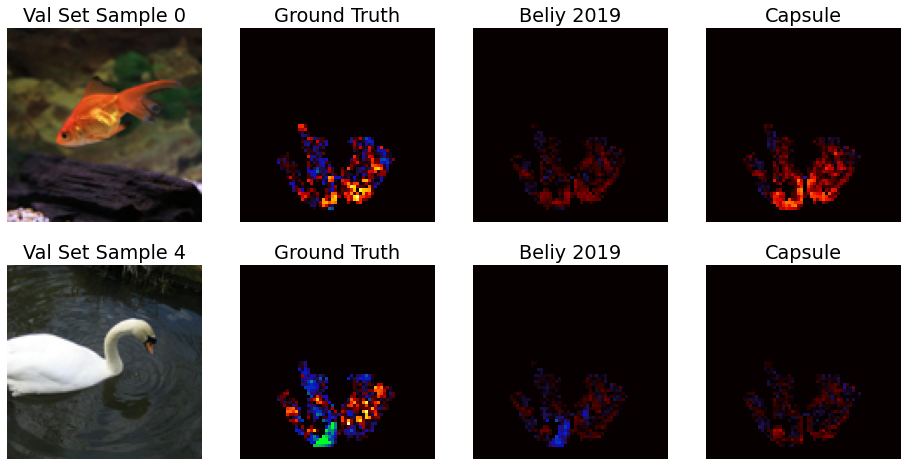

In [75]:
import matplotlib.pyplot as plt
from matplotlib import colors

# Create the actual figure
# Images used in figure 4.1 were samples 0 and 4
fig, axes = plt.subplots(2, 4, figsize = (16, 8))
MEAN_PIXELS = [123.68, 116.779, 103.939] # Note that the mean values across each channel were subtracted from the images (this was part of the beliy image preprocessing). So we have to undo that to display them

# define color map
divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
neg_cmap = np.loadtxt(join(base_dir, 'analysis/cmaps/6bluegrn_iso.cmap'), delimiter=' ')
pos_cmap = np.loadtxt(join(base_dir, 'analysis/cmaps/1hot_iso.cmap'), delimiter=' ')
cmap = colors.LinearSegmentedColormap.from_list('cold-hot', np.vstack([np.flip(neg_cmap, axis=0), pos_cmap]))

# Sample 0
# Note that if pixels are floats, imshow assumes 0-1 range, if they are integers, assumes 0-255 range
# Also note that 18 is an arbitrary slice out of the 3d volume that was chosen for the figure. It was chosen because it covers a large portion of both the lower and higher visual cortex
axes[0, 0].imshow(np.add(x_test_imagenet[0], MEAN_PIXELS).astype(int))
axes[0, 0].axis('off')
axes[0, 0].set_title('Val Set Sample 0')

axes[0, 1].imshow(np.rot90(y_test_s0.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[0, 1].axis('off')
axes[0, 1].set_title('Ground Truth')

axes[0, 2].imshow(np.rot90(beliy_pred_s0.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[0, 2].axis('off')
axes[0, 2].set_title('Beliy 2019')

axes[0, 3].imshow(np.rot90(caps_pred_s0.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[0, 3].axis('off')
axes[0, 3].set_title('Capsule')

# Sample 4
axes[1, 0].imshow(np.add(x_test_imagenet[4], MEAN_PIXELS).astype(int))
axes[1, 0].axis('off')
axes[1, 0].set_title('Val Set Sample 4')

axes[1, 1].imshow(np.rot90(y_test_s4.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[1, 1].axis('off')
axes[1, 1].set_title('Ground Truth')

axes[1, 2].imshow(np.rot90(beliy_pred_s4.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[1, 2].axis('off')
axes[1, 2].set_title('Beliy 2019')

axes[1, 3].imshow(np.rot90(caps_pred_s4.dataobj[:, :, 18]), cmap=cmap, norm=divnorm)
axes[1, 3].axis('off')
axes[1, 3].set_title('Capsule')

plt.show()

#### Creating Naive Model for ImageNet-fMRI

In [12]:
naive_pred_imagenet = np.broadcast_to(np.mean(y_train_imagenet, axis=0), shape=y_test_imagenet.shape)
naive_pred_imagenet = np.add(naive_pred_imagenet, np.random.exponential(0.04, naive_pred_imagenet.shape))

#### Table 4.1: ImageNet-fMRI Metrics

Here we calculate various evaluation metrics on the ImageNet-fMRI dataset and use bagging to generate confidence intervals on those metrics

In [34]:
from tabulate import tabulate
metrics = [mse, vc_mean, sc_mean, rs_mean]
model_preds = [beliy_pred_imagenet, caps_pred_imagenet, naive_pred_imagenet]
model_names = ['beliy', 'capsule', 'naive']
metric_names = ['MSE', 'VC', 'SC', 'RS']
bag_metrics_imagenet_set1 = {'MSE': {}, 'VC': {}, 'SC': {}, 'RS': {}}

table_text = []
for i, model_pred in enumerate(model_preds):
  row_text = []
  for j, metric in enumerate(metrics):
    vals = draw_bs_replicate(model_pred, y_test_imagenet, metric, NUM_BOOTSTRAP_REPLICATES)
    mean = np.mean(vals)
    ci = confidence_95(vals)
    std = np.std(vals)
    # print(metric_names[j], ': %f+-%f, %f, %f' % (mean, ci, std, 2*std))
    row_text.append('%f+-%f' % (mean, ci))
    bag_metrics_imagenet_set1[metric_names[j]][model_names[i]] = vals
  table_text.append(row_text)

# If one wanted to save the results
# with open('imagenet_bag_metrics.pkl', 'wb') as f:
#   pickle.dump(bag_metrics_imagenet_set1, f)

print(tabulate(table_text, headers=metric_names, showindex=model_names, tablefmt='fancy_grid'))

╒═════════╤════════════════════╤════════════════════╤════════════════════╤════════════════════╕
│         │ MSE                │ VC                 │ SC                 │ RS                 │
╞═════════╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ beliy   │ 0.062194+-0.001129 │ 0.295619+-0.013245 │ 0.502334+-0.008838 │ 0.072828+-0.001276 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ capsule │ 0.081926+-0.002004 │ 0.083402+-0.021729 │ 0.218303+-0.013195 │ 0.056965+-0.001100 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ naive   │ 0.088883+-0.001829 │ 0.000102+-0.000879 │ 0.155406+-0.005912 │ 0.038139+-0.000128 │
╘═════════╧════════════════════╧════════════════════╧════════════════════╧════════════════════╛


### 4.2 - Encoding Handwritten Digits
---

#### Calculate model predictions

In [13]:
# Calculate capsule encoder predictions
# caps_encoder_mnist = CapsEncoder(num_voxels=np.shape(y_test_mnist)[1], num_output_capsules=2, routing='dynamic', caps_act='squash')
# caps_encoder_mnist.load_weights(join(base_dir, 'trained_models/digits_encoder_test2/model_weights')).expect_partial()
# caps_pred_mnist = caps_encoder_mnist.call(x_test_mnist)

# Or load them from csv files
caps_pred_mnist = np.loadtxt(join(base_dir, 'analysis/final_results_data/caps_pred_mnist.csv'), delimiter=',')
beliy_pred_mnist = np.loadtxt(join(base_dir, 'analysis/final_results_data/beliy_pred_mnist.csv'), delimiter=',')
lcnn_pred_mnist = np.loadtxt(join(base_dir, 'analysis/final_results_data/lcnn_pred_mnist.csv'), delimiter=',')

#### Create naive model for MNIST-fMRI

In [14]:
naive_pred_mnist = np.broadcast_to(np.mean(y_train_mnist, axis=0), shape=y_test_mnist.shape)
naive_pred_mnist = np.add(naive_pred_mnist, np.random.exponential(0.04, naive_pred_mnist.shape))

#### Table 4.2: MNIST-fMRI Metrics

Calculate the various metrics on the MNIST-fMRI dataset. We also introduce an additional model called Large CNN which has the same architecture as the beliy model except the number of channels has been increased

In [36]:
from tabulate import tabulate
metrics = [mse, vc_mean, sc_mean, rs_mean]
model_preds = [beliy_pred_mnist, caps_pred_mnist, lcnn_pred_mnist, naive_pred_mnist]
model_names = ['beliy', 'capsule', 'large_cnn', 'naive']
metric_names = ['MSE', 'VC', 'SC', 'RS']
bag_metrics_mnist_set1 = {'MSE': {}, 'VC': {}, 'SC': {}, 'RS': {}}

table_text = []
for i, model_pred in enumerate(model_preds):
  row_text = []
  for j, metric in enumerate(metrics):
    vals = draw_bs_replicate(model_pred, y_test_mnist, metric, NUM_BOOTSTRAP_REPLICATES)
    mean = np.mean(vals)
    ci = confidence_95(vals)
    std = np.std(vals)
    # print(metric_names[j], ': %f+-%f, %f, %f' % (mean, ci, std, 2*std))
    row_text.append('%f+-%f' % (mean, ci))
    bag_metrics_mnist_set1[metric_names[j]][model_names[i]] = vals
  table_text.append(row_text)

# To save metrics if desired
# with open('mnist_bag_metrics.pkl', 'wb') as f:
#   pickle.dump(bag_metrics_mnist_set1, f)

print(tabulate(table_text, headers=metric_names, showindex=model_names, tablefmt='fancy_grid'))

╒═══════════╤════════════════════╤═════════════════════╤═════════════════════╤════════════════════╕
│           │ MSE                │ VC                  │ SC                  │ RS                 │
╞═══════════╪════════════════════╪═════════════════════╪═════════════════════╪════════════════════╡
│ beliy     │ 1.027159+-0.024905 │ 0.143222+-0.012255  │ 0.239750+-0.022308  │ 0.060280+-0.004336 │
├───────────┼────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ capsule   │ 1.006251+-0.019735 │ 0.188588+-0.014350  │ 0.235843+-0.009542  │ 0.207063+-0.004722 │
├───────────┼────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ large_cnn │ 0.994404+-0.028059 │ 0.193355+-0.015978  │ 0.247836+-0.014511  │ 0.202824+-0.010922 │
├───────────┼────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ naive     │ 1.086352+-0.028287 │ -0.007786+-0.001656 │ -0.010201+-0.002112 │ 0.035167+-0.000312 │


### 4.3 - Characterizing Model Behaviour
---

#### Load Beliy Encoders Trained on Positive and Negative Voxel Subsets
Here we load the predictions from the encoder trained only on the negative and positive voxel subsets. We also show exactly how these subsets are determined using the voxelwise correlations of the beliy encoder trained with all of the voxels

In [16]:
beliy_imagenet_vc = voxel_corr(beliy_pred_imagenet, y_test_imagenet)
pos_vox_subset = np.where(beliy_imagenet_vc > 0)[0]
neg_vox_subset = np.where(beliy_imagenet_vc < 0)[0]

# Beliy encoder was trained seperately on the two voxel subsets defined by pos_vox_subset and neg_vox_subset.
# We load the predictions from model trained on pos_vox_subset as well as the model trained on neg_vox_subset
beliy_pv_pred_imagenet = np.loadtxt(join(base_dir, 'analysis/final_results_data/beliy_pv_pred_imagenet.csv'), delimiter=',')
beliy_nv_pred_imagenet = np.loadtxt(join(base_dir, 'analysis/final_results_data/beliy_nv_pred_imagenet.csv'), delimiter=',')

####  Figure 4.2: Comparison of Beliy Encoder Trained with Different Subsets

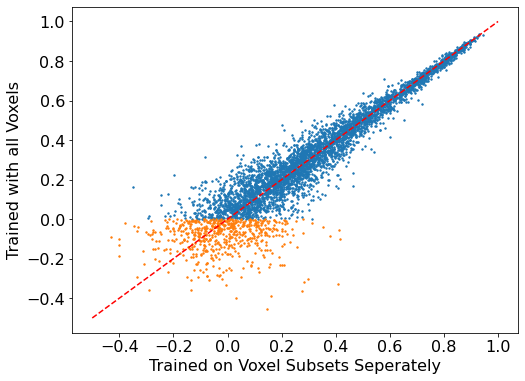

In [24]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
# Calculate the voxelwise correlations for the models trained on the pos and neg subsets
beliy_pv_imagenet_vc = voxel_corr(beliy_pv_pred_imagenet, y_test_imagenet[:, pos_vox_subset])
beliy_nv_imagenet_vc = voxel_corr(beliy_nv_pred_imagenet, y_test_imagenet[:, neg_vox_subset])

plt.figure(figsize=(8, 6))
# Plot the vc's of the model train on pos vox subset against the vc's of the model trained with all voxels
plt.scatter(beliy_pv_imagenet_vc, beliy_imagenet_vc[pos_vox_subset], s=2)
# Plot the vc's of the model train on neg vox subset against the vc's of the model trained with all voxels
plt.scatter(beliy_nv_imagenet_vc, beliy_imagenet_vc[neg_vox_subset], s=2)
plt.xlabel('Trained on Voxel Subsets Seperately')
plt.ylabel('Trained with all Voxels')
plt.plot([-0.5, 1], [-0.5, 1], '--', color='red')
plt.show()

#### Figure 4.3: Visualizing Voxelwise Correlation and Voxel Response Sensitivity in 3d Space

Again we note that for this figure we saved the desired metrics as nifti (.nii.gz) volumes and then loaded them into FSLEyes to generate the visualization of the metrics in *fMRI space* overlayed on top of the higher resolution anatomical images in *anatomical space*. Here we recreate the figure without the anatomical underlay

In [77]:
from bdpy.mri.image import export_brain_image
import nibabel
template = join(base_dir, 'kamitani_data/func_raw/sub-03_ses-perceptionTest01_task-perception_run-01_bold_preproc.nii.gz')

beliy_imagenet_vc = voxel_corr(beliy_pred_imagenet, y_test_imagenet)
caps_imagenet_vc = voxel_corr(caps_pred_imagenet, y_test_imagenet)
beliy_imagenet_rs = response_sensitivity(beliy_pred_imagenet, y_test_imagenet)
caps_imagenet_rs = response_sensitivity(caps_pred_imagenet, y_test_imagenet)

beliy_imagenet_vc_3d = export_brain_image(beliy_imagenet_vc, template=template, xyz=xyz)
caps_imagenet_vc_3d = export_brain_image(caps_imagenet_vc, template=template, xyz=xyz)
beliy_imagenet_rs_3d = export_brain_image(beliy_imagenet_rs, template=template, xyz=xyz)
caps_imagenet_rs_3d = export_brain_image(caps_imagenet_rs, template=template, xyz=xyz)

# Example on how to save fMRI nifti image as a nifti file (.nii.gz)
#nibabel.save(beliy_imagenet_vc_3d, 'beliy_imagenet_vc.nii.gz')

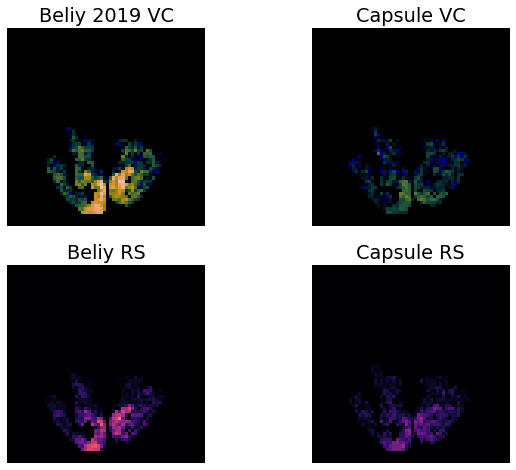

In [87]:
import matplotlib.pyplot as plt
from matplotlib import colors

# Create the actual figure
# Images used in figure 4.1 were samples 0 and 4
fig, axes = plt.subplots(2, 2, figsize = (10, 8))

# define color map
divnorm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

neg_cmap = np.loadtxt(join(base_dir, 'analysis/cmaps/black-blue.cmap'), delimiter=' ')
pos_cmap = np.loadtxt(join(base_dir, 'analysis/cmaps/savanna.cmap'), delimiter=' ')
magma = np.loadtxt(join(base_dir, 'analysis/cmaps/magma.cmap'), delimiter=' ')
vc_cmap = colors.LinearSegmentedColormap.from_list('vc', np.vstack([np.flip(neg_cmap, axis=0), pos_cmap]))
rs_cmap = colors.LinearSegmentedColormap.from_list('rs', magma)

axes[0, 0].imshow(np.rot90(beliy_imagenet_vc_3d.dataobj[:, :, 18]), cmap=vc_cmap, norm=divnorm)
axes[0, 0].axis('off')
axes[0, 0].set_title('Beliy 2019 VC')

axes[0, 1].imshow(np.rot90(caps_imagenet_vc_3d.dataobj[:, :, 18]), cmap=vc_cmap, norm=divnorm)
axes[0, 1].axis('off')
axes[0, 1].set_title('Capsule VC')

axes[1, 0].imshow(np.rot90(beliy_imagenet_rs_3d.dataobj[:, :, 18]), cmap=rs_cmap, vmax=0.5)
axes[1, 0].axis('off')
axes[1, 0].set_title('Beliy RS')

axes[1, 1].imshow(np.rot90(caps_imagenet_rs_3d.dataobj[:, :, 18]), cmap=rs_cmap, vmax=0.5)
axes[1, 1].axis('off')
axes[1, 1].set_title('Capsule RS')

plt.show()

#### Figure 4.4: Voxel RS vs Voxelwise Correlation on Imagenet-fMRI

#### Figure 4.5: Voxel RS vs Voxelwise Correlation on MNIST-fMRI

## References

[1] T. Horikawa and Y. Kamitani, “Generic decoding of seen and imagined objects using hierarchical visual features,” Nature Communications, vol. 8, no. 1, Art. no. 1, May 2017, doi: 10.1038/ncomms15037.

[2] M. A. J. van Gerven, F. P. de Lange, and T. Heskes, “Neural Decoding with Hierarchical Generative Models,” Neural Computation, vol. 22, no. 12, pp. 3127–3142, Dec. 2010, doi: 10.1162/NECO_a_00047.